In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt

import torchvision.utils as utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from sklearn.metrics import confusion_matrix

In [2]:
# CUDA Check
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Set dtype
dtype = torch.double

In [3]:

cifar_train = datasets.CIFAR10(
    root="data/",
    train=True,
    transform=transforms.ToTensor(),
    download=True)

cifar_test = datasets.CIFAR10(
    root="data/",
    train=False,
    transform=transforms.ToTensor(),
    download=True)

print(cifar_train)
print(cifar_test)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: ToTensor()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original train example # 48154
tensor([[[114., 190.,  85.],
         [113., 189.,  87.],
         [112., 188.,  87.],
         ...,
         [104., 165.,  80.],
         [106., 165.,  82.],
         [107., 165.,  87.]],

        [[122., 193., 104.],
         [120., 190., 104.],
         [119., 189., 105.],
         ...,
         [104., 166.,  78.],
         [105., 164.,  77.],
         [104., 163.,  80.]],

        [[127., 196., 110.],
         [125., 193., 110.],
         [126., 194., 113.],
         ...,
         [113., 174.,  91.],
         [107., 169.,  83.],
         [100., 169.,  79.]],

        ...,

        [[120., 167.,  53.],
         [120., 175.,  57.],
         [123., 164.,  65.],
         ...,
         [105.,  68.,  42.],
         [107.,  67.,  39.],
         [107.,  68.,  29.]],

        [[104., 156.,  43.],
         [111., 169.,  57.],
         [116., 167.,  70.],
         ...,
         [104.,  75.,  40.],
         [102.,  71.,  38.],
         [ 98.,  70.,  38.]],

     

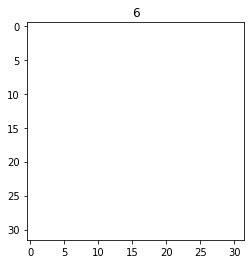

In [4]:
X_train = cifar_train.data
y_train = cifar_train.targets
X_test = cifar_test.data
y_test = cifar_test.targets

X_train=torch.tensor(X_train)
y_train=torch.tensor(y_train)
X_test=torch.tensor(X_test)
y_test=torch.tensor(y_test) #cpu tensor

X_train = X_train.to(dtype=dtype)
X_test = X_test.to(dtype=dtype)

# Data check
idx = np.random.randint(0, X_train.shape[0])
#

print("Original train example # " + str(idx))
print(X_train[idx])

plt.figure()
plt.imshow(X_train[idx], cmap='gray')
plt.title(y_train[idx].item()) #item() 텐서로 부터 값만 가져와
plt.show()

In [5]:
# Check a example's shape
shape = X_train.shape[1:]
print("Data shape : ", shape)

# Construct custom dataloader for train
class cifar_Dataset(torch.utils.data.Dataset):
    # Initialize and preprocess the data
    def __init__(self, is_train):
        # MNIST data convert to cuda tensor and change the data type
        # Train case and test case should be differentiated!
        if is_train:
            X = X_train.to(dtype=dtype)
            y = y_train.to(device=device)
        else:
            X = X_test.to(dtype=dtype)
            y = y_test.to(device=device)
        
        # Normalize
        X = self._normalize(X, 0, 255)
        
        # Reshape the data #모델에 맞춰 reshape
        X = self._reshape(X)
        
        # Move to the class object
        self.X = X
        self.y = y
    
    def __len__(self):
        # Return the data lenght
        
        return self.y.shape[0]
    
    def __getitem__(self, idx):
        # Return a idx'th item in dataset
        
        return self.X[idx], self.y[idx]
    
    def _normalize(self, data, min_value, max_value):
        # Nomalize the dataset with minimax normalizer
        
        # Arugments
        # data : tensor object for images
        # min_value : the smallest value in the data
        # max_value : the largest value in the data
        
        return (data - min_value) / (max_value - min_value)
    
    def _reshape(self, data):
        # Reshape the data
        
        # Arguments
        # data : dataset's tensor object with original image's dimension
        # shape : (batch size, 1, 28, 28)
        
        return data.view(-1, 3, 32, 32)

Data shape :  torch.Size([32, 32, 3])


In [6]:
# Hyperparameters
learning_rate = 0.1
training_epochs = 25
display_step = 5

batch_size = 100

D_in = (3, 32, 32)

batch train data example shape :  torch.Size([100, 3, 32, 32])
batch test data example :  torch.Size([100, 3, 32, 32])


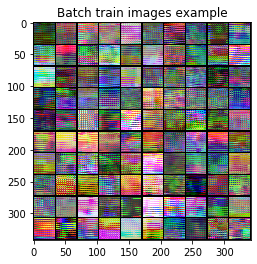

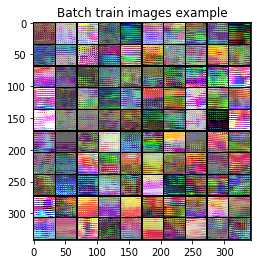

In [7]:
# Show image of batch data
def show_grid_image(img, title):
    n_img = img.shape[0]
    img = utils.make_grid(img.cpu().detach(), nrow = int(np.ceil(np.sqrt(n_img))))
    
    np_img = img.numpy()
    
    plt.figure()
    plt.imshow(np.transpose(np_img, (1, 2, 0)), cmap='gray')
    plt.title(title)
    plt.show()

# Instantiate datalodaer
train_data_loader = torch.utils.data.DataLoader(cifar_Dataset(is_train=True), batch_size, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(cifar_Dataset(is_train=False), batch_size, shuffle=True)

# Extract batch examples
batch_train_data_example, batch_train_label_example = next(iter(train_data_loader))
batch_test_data_example, batch_test_label_example = next(iter(test_data_loader))
print("batch train data example shape : ", batch_train_data_example.shape)
print("batch test data example : ", batch_test_data_example.shape)

# Show the batch images
show_grid_image(batch_train_data_example, "Batch train images example")
show_grid_image(batch_test_data_example, "Batch train images example")

In [8]:
# Initialize model parameters
def initialize_parameters(model):
    for p in model.parameters():
        if (p.dim() > 1):
            torch.nn.init.xavier_normal_(p)
        else:
            torch.nn.init.uniform_(p, 0.1, 0.2)

In [11]:
# Construct a convolution neural netwok
class CNN(torch.nn.Module):
    def __init__(self):
        # Initialize model parameters
        super(CNN, self).__init__()
        # Layer1 structure - Input: (-, 28, 28, 1)
        # (-, 34, 34, 1) --Conv2d--> (-, 32, 32, 32) NEW!
        # (-, 32, 32, 32) --ReLU--> (-, 32, 32, 32)
        # (-, 32, 32, 32) --MaxPool2d--> (-, 16, 16, 32) NEW!
        
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Layer 2 structure - Input: (-, 16, 16, 32)
        # (-, 16, 16, 32) --Conv2d--> (-, 14, 14, 32)
        # (-, 14, 14, 64) --ReLU--> (-, 14, 14, 64)
        # (-, 14, 14, 64) --MaxPool2d--> (-, 7, 7, 64)
        
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            #stride 옆으로 넘어가는 정도
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Fully connected structure - Input: (-, 7, 7, 64)
        # Make input be flat
        
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)
        
    def forward(self, x):
        # Calculate the forward process
        
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.fc(output.view(output.size(0), -1))
        
        return output

# Make the model
model = CNN().to(dtype=dtype, device=device)

# Set loss function and optimizer
criterion = torch.nn.CrossEntropyLoss(reduction="mean")
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [14]:
losses = []

model.train()
initialize_parameters(model)

print("Training...")

for epoch in range(training_epochs):
    avg_loss = 0
    
    for data in train_data_loader:
        images, labels = data
        images=images.to(device=device)
        labels=labels.to(device=device)
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        avg_loss += loss.item() / batch_size
        
        loss.backward()
        optimizer.step()
    
    losses.append(avg_loss)
    
    if (epoch + 1) % display_step == 0:
        print("epoch " + str(epoch + 1) + " : ", losses[-1])
    
print("Finsh training")

# Save the model parameters
torch.save(model.state_dict(), "cnn.pt")

Training...
epoch 5 :  7.403579501277105
epoch 10 :  6.343807953662226
epoch 15 :  5.64239440265835
epoch 20 :  5.055591354550626
epoch 25 :  4.59691949278115
Finsh training
